In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sim import Simulator
from tqdm.notebook import tqdm
from exact_planners import CvxPlanner, NaivePlanner
from distributed_planners import *
from matplotlib import animation
from IPython.display import HTML
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

In [2]:
n = 5000
N = 2
A = 5
I = 3
M = 5
C = 3
P = M + C

data = dict()

def animate(key, data):
    bots = data[key]['bots']
    pick_ups = data[key]['pick_ups']
    drop_offs = data[key]['drop_offs']
    chargers = data[key]['chargers']
    charges = data[key]['charges']

    # animate the pendulum
    fig = plt.figure()
    ax = fig.add_subplot(111, autoscale_on=False, xlim=(0, 1), ylim=(0, 1))
    ax.grid()

    bot_plots = []
    for b in range(A):
        bot_plot, = ax.plot([], [], 'o', lw=2, color=np.random.random((3,)), label='')
        bot_plots.append(bot_plot)
    mission_plots = []
    for m in range(M):
        mission_plot, = ax.plot([], [], '-o', lw=2, color=(0.9, 0.4, 0.4))
        mission_plots.append(mission_plot)

    for c in range(C):
        ax.plot([ chargers[c,0] ], [ chargers[c,1] ], 's', lw=2, color=(0.9, 0.4, 0.4))

    def init():
        for b in range(A):
            bot_plots[b].set_data([], [])
        for m in range(M):
            mission_plots[m].set_data([], [])
        return bot_plot, *mission_plots

    def animate(i):
        for m in range(M):
            mission_plots[m].set_data([ pick_ups[i,m,0], drop_offs[i,m,0] ], [ pick_ups[i,m,1], drop_offs[i,m,1] ])
        for b in range(A):
            bot_plots[b].set_data(bots[i,b,0], bots[i,b,1])
        return bot_plot, *mission_plots

    ax.legend()

    ani = animation.FuncAnimation(fig, animate, np.arange(n), interval=50, blit=True, init_func=init)
    # make the animation show in my jupyter notebook
    return ani

In [3]:
cvx_planner = CvxPlanner(A, P)
naive_planner = NaivePlanner(A, P)
exactAvgW_planner = ExactAvgW(A, P)
exactAvgU_planner = ExactAvgU(A, P)
pgdU_planner = PgdU(A, P)
pgdW_planner = PgdW(A, P)

planners = {
    'naive': naive_planner,
    'cvx': cvx_planner,
    'pgdU': pgdU_planner,
    'pgdW': pgdW_planner,
    'exactU': exactAvgU_planner,
    'exactW': exactAvgW_planner,
}

In [4]:
for key, planner in planners.items():
    np.random.seed(5)
    sim = Simulator(A, M, C, 2, fuel_efficiency=0.2, radius=I, dt = 0.005)

    bots = np.zeros((n,A,N))
    pick_ups = np.zeros((n,M,N))
    drop_offs = np.zeros((n,M,N))
    Cs = np.zeros((n,A,A,A))
    Ws = np.zeros((n,A,A,A))
    Ts = np.zeros((n,A,A,P))
    Ls = np.zeros((n,A,A,P))
    Ct = np.zeros((n,A,A,A))
    Wt = np.zeros((n,A,A,A))
    Tt = np.zeros((n,A,A,P))
    Lt = np.zeros((n,A,A,P))
    charges = np.zeros((n,A))
    chargers = sim.chargers.copy()

    for k in tqdm(range(n)):
        sim.step()

        bots[k] = sim.bots.copy()
        pick_ups[k] = sim.pick_ups.copy()
        drop_offs[k] = sim.drop_offs.copy()
        charges[k] = sim.charge.copy()
        Cs[k] = sim.graph.C.copy()

        if key in ['cvx', 'naive']:
            sim.plans[:] = planner(sim.cost)
            Cs[k,:] = sim.graph.C
            Ls[k,:] = sim.cost
            Ws[k,:] = sim.graph.W
            Ts[k] = sim.plans
        else:
            sim.plans = planner(sim.graph.C, sim.cost)
            Cs[k] = planner.C
            Ls[k] = planner.L
            Ws[k] = planner.W
            Ts[k] = planner.T
        
        Ct[k,:] = sim.graph.C
        Wt[k,:] = sim.graph.W
        Lt[k,:] = sim.cost
        Tt[k,:] = cvx_planner(sim.cost)

    data[key] = dict()
    data[key]['bots'] = bots
    data[key]['pick_ups'] = pick_ups
    data[key]['drop_offs'] = drop_offs
    data[key]['charges'] = charges
    data[key]['Ct'] = Ct
    data[key]['Lt'] = Lt
    data[key]['Tt'] = Tt
    data[key]['Wt'] = Wt
    data[key]['Cs'] = Cs
    data[key]['Ws'] = Ws
    data[key]['Ls'] = Ls
    data[key]['Ts'] = Ts
    data[key]['chargers'] = chargers
    data[key]['stats'] = [
        sim.time_elapsed,
        sim.time_wasted,
        sim.missions_completed
    ]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

c:\Users\oscar\Desktop\School\EE364P\distributed_planners.py:134: ComplexWarning: Casting complex values to real discards the imaginary part
  self.W05[a] = self.W10[a] - eigstep_RK4(alpha, self.W10[a])
c:\Users\oscar\miniconda3\lib\site-packages\cvxpy\problems\problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

                 & time       & m     & L     & T     & A     & W     \\
naive            & 278183     & 30    & 0.00  & 4.59  & 0.00  & 0.57  \\
exact            & 229395     & 45    & 0.00  & 0.00  & 0.00  & 0.56  \\
iterative        & 232954     & 37    & 10.11 & 3.43  & 7.75  & 0.80  \\
iterative + mix  & 201695     & 44    & 10.06 & 3.18  & 6.32  & 0.38  \\
share            & 251752     & 41    & 1.73  & 1.12  & 7.75  & 0.80  \\
share + mix      & 270589     & 36    & 1.74  & 1.36  & 0.52  & 0.61  \\
n       A       I       M       C       dt     
5000.00 5.00    3.00    5.00    3.00    0.01   


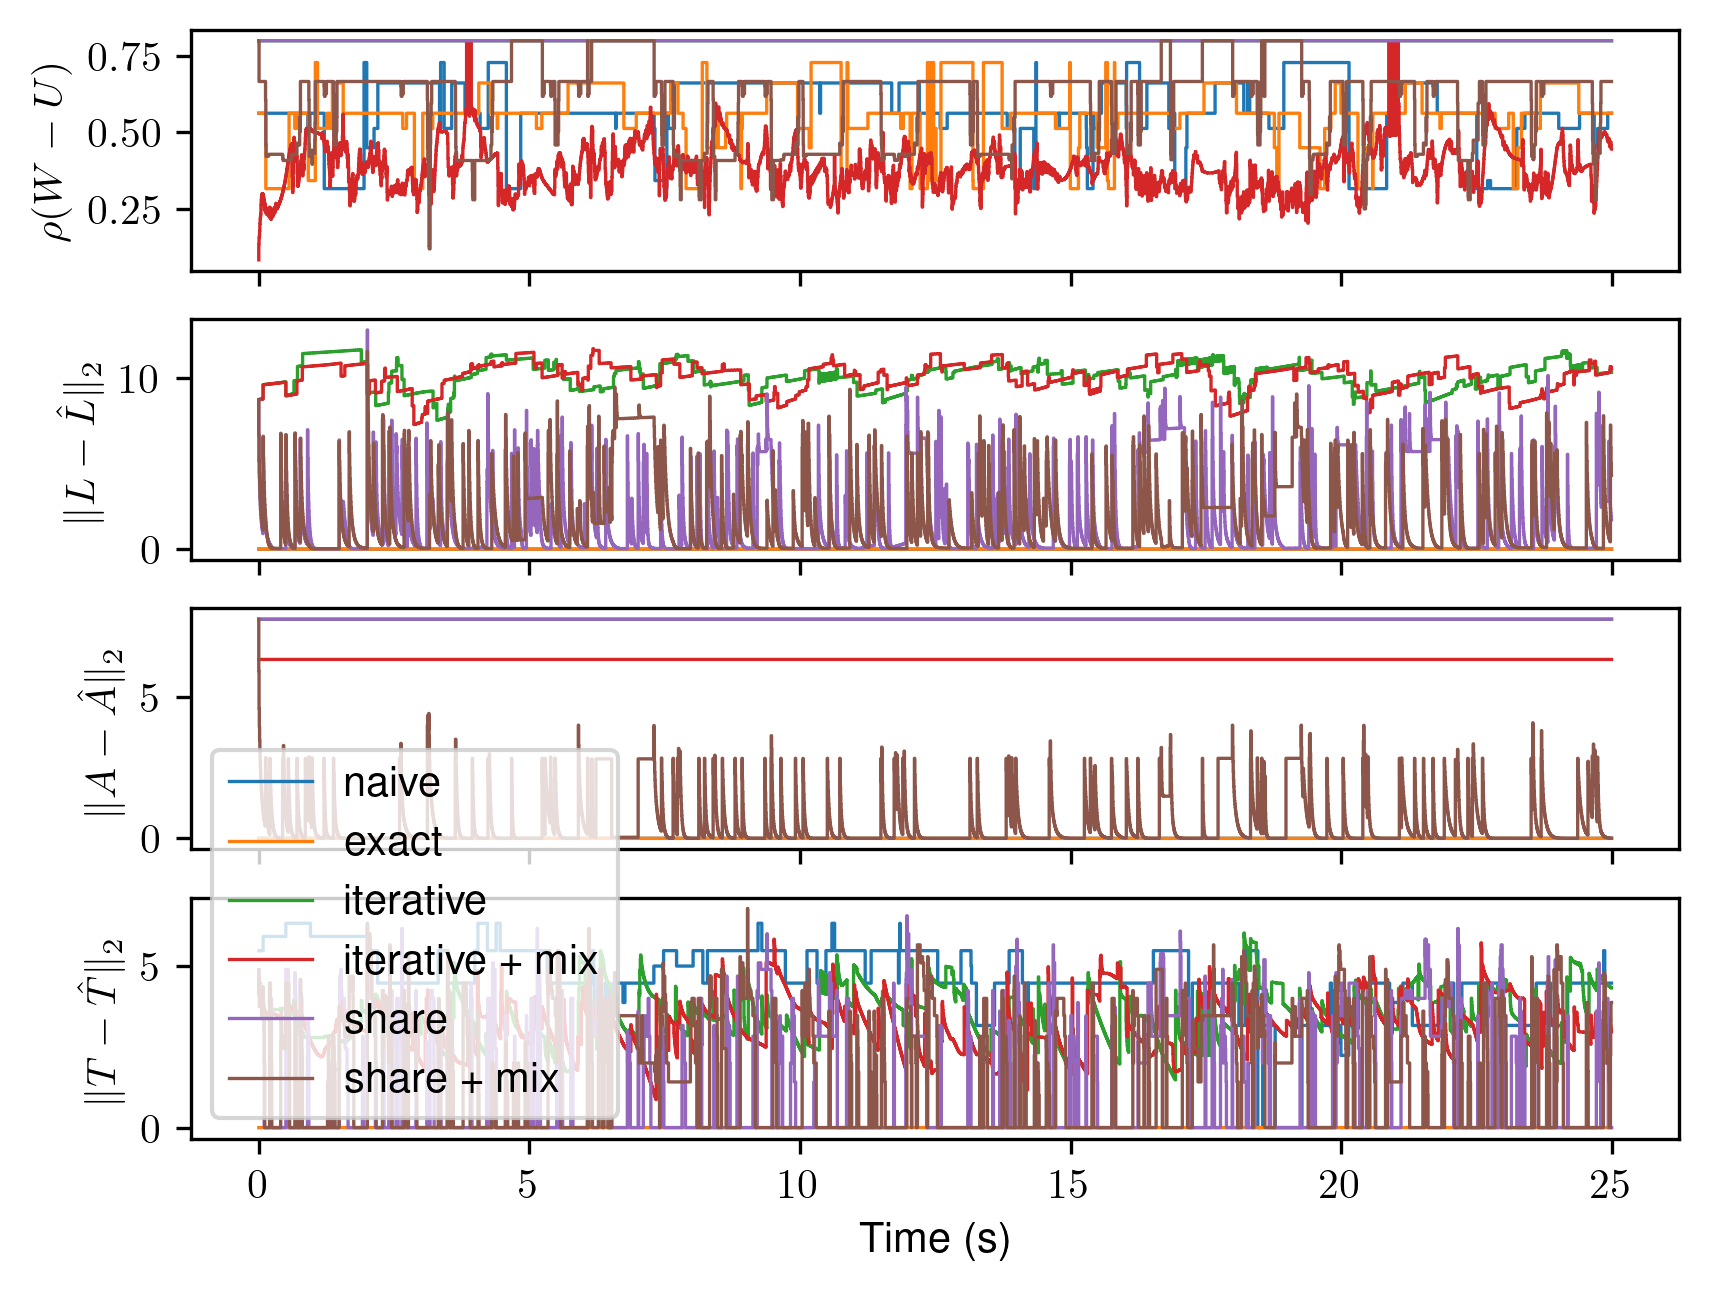

In [18]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, sharex=True)
fig.size = (20, 20)
ax1.set_ylabel(r'$\rho(W-U)$', fontsize=10)
ax2.set_ylabel(r'$\|L-\hat{L}\|_2$', fontsize=10)
ax3.set_ylabel(r'$\|A-\hat{A}\|_2$', fontsize=10)
ax4.set_ylabel(r'$\|T-\hat{T}\|_2$', fontsize=10)
iterations = np.arange(n) * sim.dt
names = {
    'naive' : 'naive',
    'cvx' : 'exact',
    'pgdU' : 'iterative',
    'pgdW' : 'iterative + mix',
    'exactU' : 'share',
    'exactW' : 'share + mix',
}
print(f'{"":16} & {"time":10} & {"m":5} & {"L":5} & {"T":5} & {"A":5} & {"W":5} \\\\')
for key in data:
    D = data[key]
    radi = np.zeros((n,))
    C_error = np.zeros((n,))
    L_error = np.zeros((n,))
    T_error = np.zeros((n,))
    for k in range(n):
        radi[k] = radius(np.mean(D['Ws'][k], axis=0))
        L_error[k] = np.linalg.norm((D['Lt'][k] - D['Ls'][k]).ravel())
        C_error[k] = np.linalg.norm((D['Ct'][k] - D['Cs'][k]).ravel())
        T_error[k] = np.linalg.norm((D['Tt'][k] - D['Ts'][k]).ravel())
    name = names[key]
    ax1.step(iterations, radi, label=name, linewidth=0.8)
    ax2.step(iterations, L_error, label=name, linewidth = 0.8)
    ax3.step(iterations, C_error, label=name, linewidth = 0.8)
    ax4.step(iterations, T_error, label=name, linewidth = 0.8)
    D = [ data[key]['stats'][1], data[key]['stats'][2], np.mean(L_error), np.mean(T_error), np.mean(C_error), np.mean(radi) ]
    S = [ f'{D[0]:.0f}', f'{D[1]:.0f}', f'{D[2]:.2f}', f'{D[3]:.2f}', f'{D[4]:.2f}', f'{D[5]:.2f}' ]
    #print('&'.join([name] + [f'{d:.2f}' for d in D]) + '\\\\')
    print(f'{name:16} & {S[0]:10} & {S[1]:5} & {S[2]:5} & {S[3]:5} & {S[4]:5} & {S[5]:5} \\\\')

S = [ 'n', 'A', 'I', 'M', 'C', 'dt' ]
V = [ n, A, I, M, C, sim.dt ]
VS = [ f'{k:7}' for k in S ]
VV = [ f'{k:.2f}' for k in V ]
VVS = [ f'{k:7}' for k in VV ]
print(*VS)
print(*VVS)

plt.xlabel('Time (s)')
plt.legend()
fig.set_dpi(300)

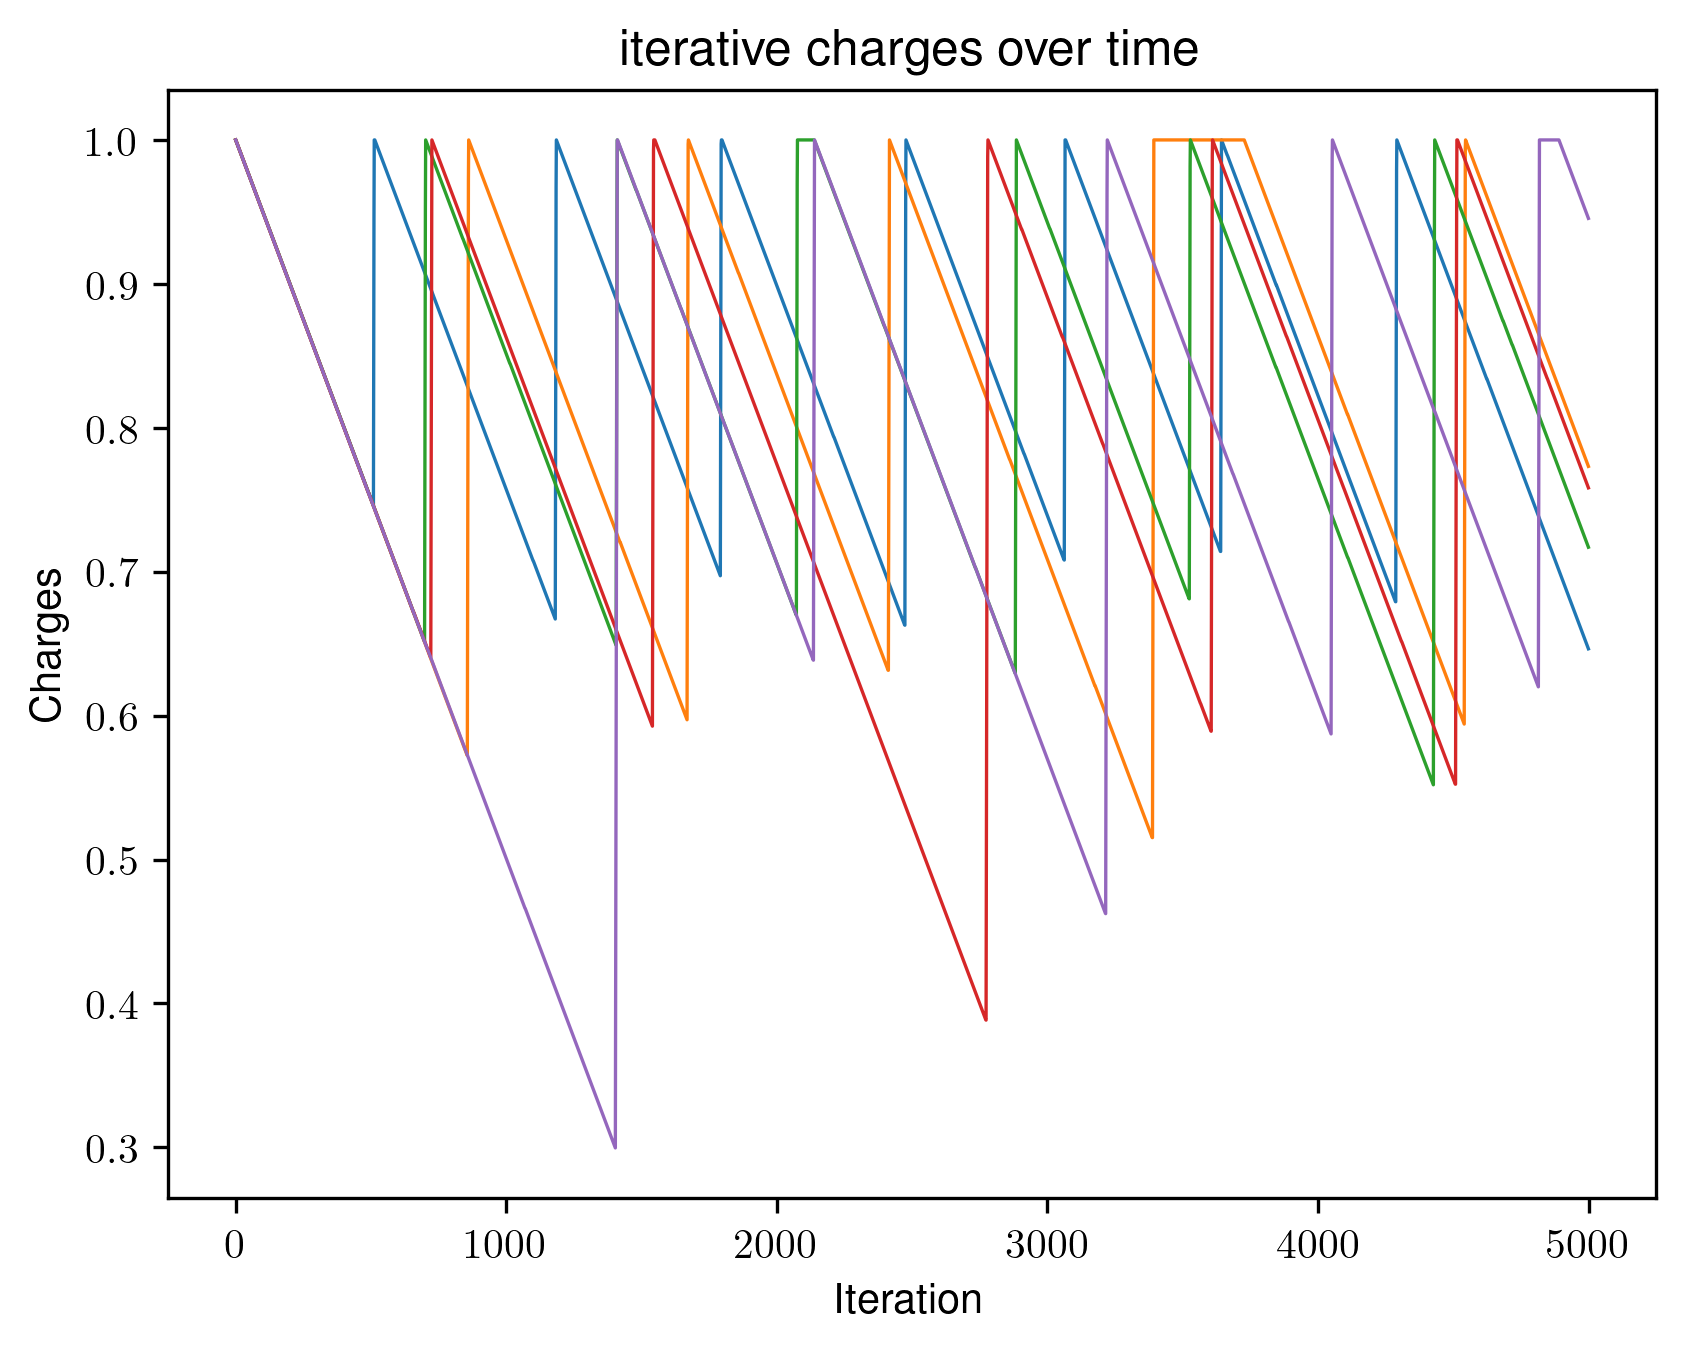

In [19]:
for k, key in enumerate(data):
    if key != 'pgdU':
        continue
    name = names[key]
    plt.figure(k)
    plt.plot(data[key]['charges'], label=key, linewidth=0.8)
    plt.ylabel('Charges')
    plt.xlabel('Iteration')
    plt.title(name + ' charges over time')
    plt.gcf().set_dpi(300)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


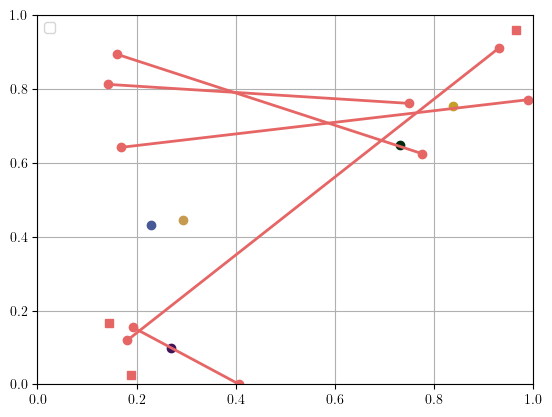

In [9]:
ani = animate('cvx', data)
HTML(ani.to_html5_video())